## StarGAN

## 라이브러리 다운로드 및 초기 설정

In [1]:
!pip install nnabla-ext-cuda120  # 해당 라이브러리는 지속적으로 업데이트되므로 실행 시점에 오류가 발생할 수도 있습니다.
!git clone https://github.com/sony/nnabla-examples.git

fatal: destination path 'nnabla-examples' already exists and is not an empty directory.


In [2]:
!wget -O /content/man.png https://raw.githubusercontent.com/Lilcob/test_colab/main/man.png

--2024-03-13 04:44:49--  https://raw.githubusercontent.com/Lilcob/test_colab/main/man.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1654381 (1.6M) [image/png]
Saving to: ‘/content/man.png’

/content/man.png    100%[===================>]   1.58M  --.-KB/s    in 0.02s   

2024-03-13 04:44:49 (79.1 MB/s) - ‘/content/man.png’ saved [1654381/1654381]



In [3]:
# 런타임 재시작 후 이 코드 실행
%run nnabla-examples/interactive-demos/colab_utils.py
%cd nnabla-examples/image-translation/stargan


/content/nnabla-examples/image-translation/stargan


get StarGAN pretrained weights.  

get StarGAN config file.

## 모델과 가중치 파일 다운로드

In [4]:
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json

--2024-03-13 04:44:49--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5
Resolving nnabla.org (nnabla.org)... 18.239.69.119, 18.239.69.122, 18.239.69.20, ...
Connecting to nnabla.org (nnabla.org)|18.239.69.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212881888 (203M) [binary/octet-stream]
Saving to: ‘pretrained_params_on_celebA.h5.1’

pretrained_params_o 100%[===================>] 203.02M   451MB/s    in 0.5s    

2024-03-13 04:44:50 (451 MB/s) - ‘pretrained_params_on_celebA.h5.1’ saved [212881888/212881888]

--2024-03-13 04:44:50--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json
Resolving nnabla.org (nnabla.org)... 18.239.69.119, 18.239.69.122, 18.239.69.20, ...
Connecting to nnabla.org (nnabla.org)|18.239.69.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775 [application/json]
Saving to: ‘pretrained_conf_on_celebA.json.1’



## 모듈 불러오기

In [5]:
import os
import cv2
import numpy as np
import shutil   # ①
import glob
from skimage import io, color   # ②
import dlib # ③
import matplotlib.pyplot as plt
from IPython.display import Image, display
from google.colab import files

## 추론에 필요한 함수 선언

In [6]:
def upload_image(): # ①
    img = '/content/man.png'
    ext = os.path.splitext(img)[-1]
    os.rename(img, "input_image{}".format(ext))
    input_img = "input_image" + ext
    return input_img, ext

def download_and_unzip_dlib_model():    # ②
    !wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
    !bzip2 -d mmod_human_face_detector.dat.bz2

def detect_face(image_path):    # ③
    image = io.imread(image_path)
    if image.ndim == 2:
        image = color.gray2rgb(image)
    elif image.shape[-1] == 4:
        image = image[..., :3]
    face_detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
    detected_faces = face_detector(cv2.cvtColor(image[..., ::-1].copy(), cv2.COLOR_BGR2GRAY))
    detected_faces = [[d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()] for d in detected_faces]
    assert len(detected_faces) == 1, "Warning: only one face should be contained."
    detected_faces = detected_faces[0]
    return detected_faces, image

def transform(point, center, scale, resolution, invert=False):  # ①
    point.append(1)
    h = 200.0 * scale
    t = np.eye(3)
    t[0, 0] = resolution / h
    t[1, 1] = resolution / h
    t[0, 2] = resolution * (-center[0] / h + 0.5)
    t[1, 2] = resolution * (-center[1] / h + 0.5)
    if invert:
        t = np.reshape(np.linalg.inv(np.reshape(t, [1, 3, 3])), [3, 3])
    new_point = np.reshape(np.matmul(
        np.reshape(t, [1, 3, 3]), np.reshape(point, [1, 3, 1])), [3, ])[0:2]
    return new_point.astype(int)

def crop(image, center, scale, resolution=256): # ②
    ul = transform([1, 1], center, scale, resolution, True)
    br = transform([resolution, resolution], center, scale, resolution, True)

    if image.ndim > 2:
        new_dim = np.array([br[1] - ul[1], br[0] - ul[0],
                            image.shape[2]], dtype=np.int32)
        new_img = np.zeros(new_dim, dtype=np.uint8)
    else:
        new_dim = np.array([br[1] - ul[1], br[0] - ul[0]], dtype=np.int)
        new_img = np.zeros(new_dim, dtype=np.uint8)

    ht, wd = image.shape[0], image.shape[1]
    new_x = np.array([max(1, -ul[0] + 1), min(br[0], wd) - ul[0]], dtype=np.int32)
    new_y = np.array([max(1, -ul[1] + 1), min(br[1], ht) - ul[1]], dtype=np.int32)
    old_x = np.array([max(1, ul[0] + 1), min(br[0], wd)], dtype=np.int32)
    old_y = np.array([max(1, ul[1] + 1), min(br[1], ht)], dtype=np.int32)

    new_img[new_y[0] - 1:new_y[1], new_x[0] - 1:new_x[1]] = image[old_y[0] - 1:old_y[1], old_x[0] - 1:old_x[1], :]
    new_img = cv2.resize(new_img, dsize=(int(resolution), int(resolution)),
                         interpolation=cv2.INTER_LINEAR)
    return new_img

def crop_face(detected_faces, image):   # ③
    center = [
        detected_faces[2] - (detected_faces[2] - detected_faces[0]) / 2.0,
        detected_faces[3] - (detected_faces[3] - detected_faces[1]) / 2.0
    ]
    scale = (detected_faces[2] - detected_faces[0] + detected_faces[3] - detected_faces[1]) / 195
    cropped_image = crop(image, center, scale, resolution=128)
    return cropped_image

def save_and_move_cropped_image(cropped_image):
    io.imsave("cropped_image.png", cropped_image)
    source_dir = "source_img"
    os.makedirs(source_dir, exist_ok=True)
    shutil.move("cropped_image.png", f"source_img/input_image.png")

def generate_new_image():
    !python generate.py --pretrained-params pretrained_params_on_celebA.h5 --config pretrained_conf_on_celebA.json --test-image-path source_img
    generated_img = sorted(glob.glob(os.path.join("tmp.results/*.png")), key=os.path.getmtime)[-1]
    return generated_img

## 이미지 생성 함수 선언

In [7]:
def prep_image():
    input_img, ext = upload_image()
    download_and_unzip_dlib_model()
    detected_faces, image = detect_face(input_img)
    cropped_image = crop_face(detected_faces, image)
    save_and_move_cropped_image(cropped_image)
    print("Cropped image")
    plt.imshow(cropped_image)

def gen_image():
    generated_img = generate_new_image()
    display(Image(generated_img))

## 스타일 변환에 사용할 이미지 업로드

--2024-03-13 04:44:50--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  1.08MB/s    in 0.6s    

2024-03-13 04:44:51 (1.08 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]

bzip2: Output file mmod_human_face_detector.dat already exists.
Cropped image


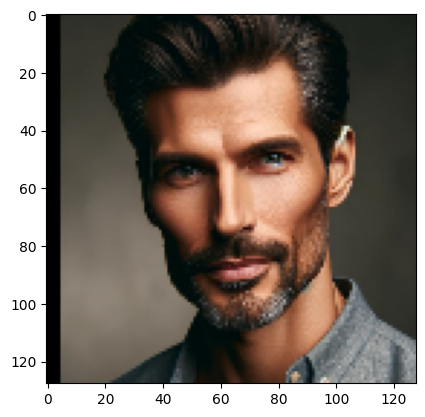

In [8]:
prep_image()

## 업로드된 이미지 스타일 변환

2024-03-13 04:44:53,093 [nnabla][INFO]: Initializing CPU extension...
2024-03-13 04:44:53,520 [nnabla][INFO]: Initializing CUDA extension...
2024-03-13 04:44:53,528 [nnabla][INFO]: Initializing cuDNN extension...
Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
Source image: input_image.png
Use 'Black_Hair'?
type yes or no: yes
Use 'Blond_Hair'?
type yes or no: yes
Use 'Brown_Hair'?
type yes or no: yes
Use 'Male'?
type yes or no: yes
Use 'Young'?
type yes or no: yes
Saved tmp.results/generated_0_Black_Hair_Blond_Hair_Brown_Hair_Male_Young.png.


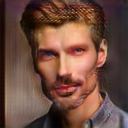

In [9]:
gen_image()